In [1]:
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
%matplotlib inline 

In [2]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

In [3]:
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [4]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


In [5]:
chm_file = './data/2017/NEON_D17_SJER_DP3_258000_4108000_CHM.tif'

In [6]:
#Get info from chm file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")


In [7]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [8]:
just_chm_file


'NEON_D17_SJER_DP3_258000_4108000_CHM.tif'

In [9]:
just_chm_file_split

['NEON', 'D17', 'SJER', 'DP3', '258000', '4108000', 'CHM.tif']

In [10]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

#Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)


In [11]:
#Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

In [12]:
#Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

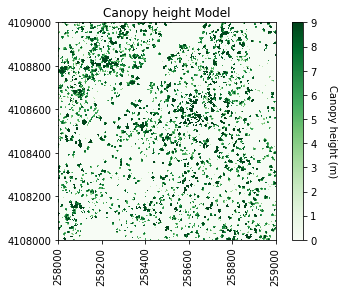

In [13]:
#Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

#PLot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, 9])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)


In [14]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

## ??????????????????????????????????????????

In [15]:
#Save the smoothed CHM, #32611 is the format of the data file
array2raster('./data/2017/chm_filter.tif',(xMin,yMax),1,-1,np.array(chm_array_smooth/10000,dtype=float),32611)

In [16]:
 #Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((5, 5)))

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

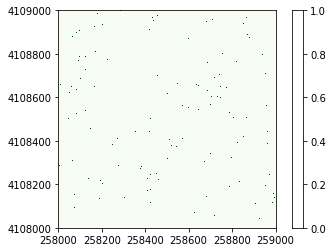

In [17]:
#Plot the local maximums
plt.figure(2)
plot_band_array(local_maxi,image_extent,'Maximum','Maxi','Greys',[0, 1])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Maximums.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)


In [18]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

In [19]:
#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth != 0] = 1

In [20]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm_mask)

In [21]:
#Get the properties of each segment
tree_properties = regionprops(labels,chm_array, ['Area','BoundingBox','Centroid','Orientation','MajorAxisLength','MinorAxisLength','MaxIntensity','MinIntensity'])

## ??????????????????????????????????????

In [22]:
#Determine how many individual trees were identified
max_labels = labels.max()
segment_labels = np.zeros(max_labels+1)
segment_id = np.zeros(max_labels+1)

for counter in range (1,max_labels+1):
    segment_labels[counter] = len(labels[labels==counter])
    segment_id[counter]=counter

#Remove the non-zero elements
segment_id = segment_id[np.nonzero(segment_labels)]

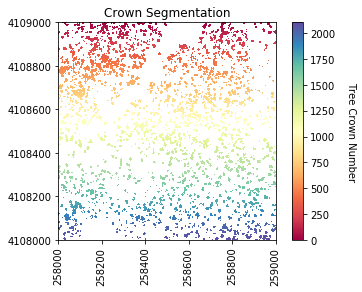

In [23]:
#Change the lebels to flow and plot them and save as raster
labels = np.array((labels),dtype=float)
plt.figure(3)
array2raster('./data/2017/SegmentedData.tif',(xMin,yMax),1,-1,labels,32611)
#Change the zero labels to nans so they won't show up in the plot
labels[labels==0] = np.nan

#Plot the segments      
plot_band_array(labels,image_extent,'Crown Segmentation','Tree Crown Number','Spectral',[0, max_labels])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Segmentation.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

In [24]:
#Define several of the predictor variables
area=np.zeros(len(tree_properties))
diameter=np.zeros(len(tree_properties))
max_tree_height=np.zeros(len(tree_properties))
min_tree_height=np.zeros(len(tree_properties))

#Retreive the predictor variables from the region properties
for counter in range(0,len(tree_properties)):

    area[counter] = tree_properties[counter]['Area']
    diameter[counter] = tree_properties[counter]['MajorAxisLength']        
    max_tree_height[counter] =  tree_properties[counter]['MaxIntensity']    
    min_tree_height[counter] = tree_properties[counter]['MinIntensity']  


C:\Users\Smells\Anaconda3\envs\p35\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\Smells\Anaconda3\envs\p35\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [25]:
#Define the remaining predictor variables

crown_geometric_volume_full=np.zeros(len(segment_id))
crown_geometric_volume_50th_percentile=np.zeros(len(segment_id))
crown_geometric_volume_60th_percentile=np.zeros(len(segment_id))
crown_geometric_volume_70th_percentile=np.zeros(len(segment_id))
percentile_50th=np.zeros(len(segment_id))
percentile_60th=np.zeros(len(segment_id))
percentile_70th=np.zeros(len(segment_id))

In [26]:
#Cycle through all of the tree segments    
counter=0
for segment in segment_id:
    #Pull out the tree of interest
    indexes_of_tree = np.asarray(np.where(labels==segment)).T
    tree_data = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    #Calculate the geometric volume 
    crown_geometric_volume_full[counter]=np.sum([tree_data-np.min(tree_data)])

    #Pull out 50th percentile stats
    percentile_50th[counter]=np.percentile(tree_data,50)
    tree_data_50th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_50th[tree_data_50th>percentile_50th[counter]] = percentile_50th[counter]
    crown_geometric_volume_50th_percentile[counter]=np.sum([tree_data_50th-min_tree_height[counter]])

    #Pull out 60th percentile stats    
    percentile_60th[counter]=np.percentile(tree_data,60)
    tree_data_60th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_60th[tree_data_60th>percentile_60th[counter]] = percentile_60th[counter]
    crown_geometric_volume_60th_percentile[counter]=np.sum([tree_data_60th-min_tree_height[counter]])

    #Pull out 60th percentile stats 
    percentile_70th[counter]=np.percentile(tree_data,70)
    tree_data_70th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_70th[tree_data_70th>percentile_70th[counter]] = percentile_70th[counter]
    crown_geometric_volume_70th_percentile[counter]=np.sum([tree_data_70th-min_tree_height[counter]])

    counter=counter+1